In [1]:
import sys
sys.path.append('/lmh_data/work/SEE/train/')
sys.path.append('/lmh_data/work/SEE/analyse/')

import anndata
import numpy as np
import pandas as pd
import h5py
from scipy import stats

from util import array2mat, mat2array

import matplotlib.pyplot as plt
import seaborn as sns
from analyse_util import figure_size, set_plt, set_Border

In [2]:
np.random.seed(0)

In [3]:
cerebellum_astro = h5py.File('/lmh_data/data/sclab/Astro_bulk_hic/ENCFF027IEO.h5', 'r')
spinal_cord_astro = h5py.File('/lmh_data/data/sclab/Astro_bulk_hic/ENCFF715HDW.h5', 'r')

In [4]:
def get_bulk_interactions(_bulk, _chr: int, _start: int, _end: int):
    _positions = pd.DataFrame(_bulk['bin_positions'])
    _start_index = _positions[(_positions[0] == _chr)&(_positions[1] == _start)].index[0]
    _end_index = _positions[(_positions[0] == _chr)&(_positions[1] == _end)].index[0]
    return _bulk['interactions'][_start_index:_end_index+1, _start_index:_end_index+1]

In [5]:
gene_name, cell_type = 'SLC1A2', 'Astro'

rna = anndata.read_h5ad('/lmh_data/data/sclab/sclab/rna_result.h5ad')
gene_info = rna.var.loc[gene_name]
_chr, _start, _end = int(gene_info['chrom'][3:]), int(gene_info['chromStart']), int(gene_info['chromEnd'])

_schic_start, _schic_end = int(int(_start/10000)*10000), int(int(_end/10000)*10000)
_bulk_start, _bulk_end = int(int(_start/40000)*40000), int(int(_end/40000)*40000)
_schic_range = list(range(_schic_start, _schic_end+10000, 10000))
_bulk_range = list(range(_bulk_start, _bulk_end+40000, 40000))

cerebellum_interactions = get_bulk_interactions(cerebellum_astro, _chr=_chr-1, _start=_bulk_start+1, _end=_bulk_end+1)
spinal_cord_interactions = get_bulk_interactions(spinal_cord_astro, _chr=_chr-1, _start=_bulk_start+1, _end=_bulk_end+1)
_bulk_shape = cerebellum_interactions.shape


In [6]:
eval_set = np.load('/lmh_data/data/sclab/sclab/eval_dataset.npy', allow_pickle=True)
preds = np.load('/lmh_data/data/sclab/sclab/tmp/{}/evaluate.npy'.format(gene_name), allow_pickle=True)

In [7]:
def get_schic():
    _preds, _targets = [], []
    for i in range(len(preds)):
        pred = preds[i]
        if eval_set[i]['cell_type'] != cell_type:
            continue
        _pred = pred['predict'].copy() + abs(pred['predict'].copy().min())
        _target = pred['target'].copy()
        _pred = _pred / _pred.max()
        _target = _target / _target.max()
        _preds.append(_pred)
        _targets.append(_target)
    return _preds, _targets

pred_hic, target_hic = get_schic()

In [8]:
def get_shuffle(_array):
    _where = np.where(np.ones(_array.shape))[0]
    _p = _array / _array.sum()
    _array = np.zeros(_array.shape)
    for i in np.random.choice(_where, int(_array.shape[0]/20), p=_p):
        _array[i] += 1
    return _array

def _reshape(_mat, _shape, _bulk_range):
    _reshape_mat = np.zeros(_shape)
    for i in range(len(_bulk_range)):
        _start1, _end1 = _bulk_range[i], _bulk_range[i] + 40000
        _range1 = np.where((np.array(_schic_range)>=_start1)&(np.array(_schic_range)<_end1))[0]
        _part_mat1 = _mat[_range1]
        for j in range(i, len(_bulk_range)):
            _start2, _end2 = _bulk_range[j], _bulk_range[j] + 40000
            _range2 = np.where((np.array(_schic_range)>=_start2)&(np.array(_schic_range)<_end2))[0]
            _part_mat2 = _part_mat1[:, _range2]
            _reshape_mat[i, j] = _part_mat2.mean()
        
    _reshape_mat = _reshape_mat + np.triu(_reshape_mat, k=1).T
    return _reshape_mat

def cal_pearson(_schic, _schic_range, _bulk, _bulk_range, _nums):
    _array = np.zeros(_schic[0].shape)
    for i in range(_nums):
        _array += get_shuffle(_schic[i])
#     _array = np.array(_schic[:_nums]).mean(axis=0)
    _mat = array2mat(_array)
    
    _reshape_mat = _reshape(_mat, _bulk.shape, _bulk_range)
    
#     fig = plt.figure(figsize=[7, 7])
#     ax = fig.add_subplot()
#     sns.heatmap(_reshape_mat, cmap='Reds_r', square=True)
    
    return stats.pearsonr(_reshape_mat.reshape(-1), _bulk.reshape(-1))[0]

    _reshape_mat = np.triu(_reshape_mat, k=1).reshape(-1)
    _bulk = np.triu(_bulk, k=1).reshape(-1)
    return stats.pearsonr(_reshape_mat, _bulk)[0]

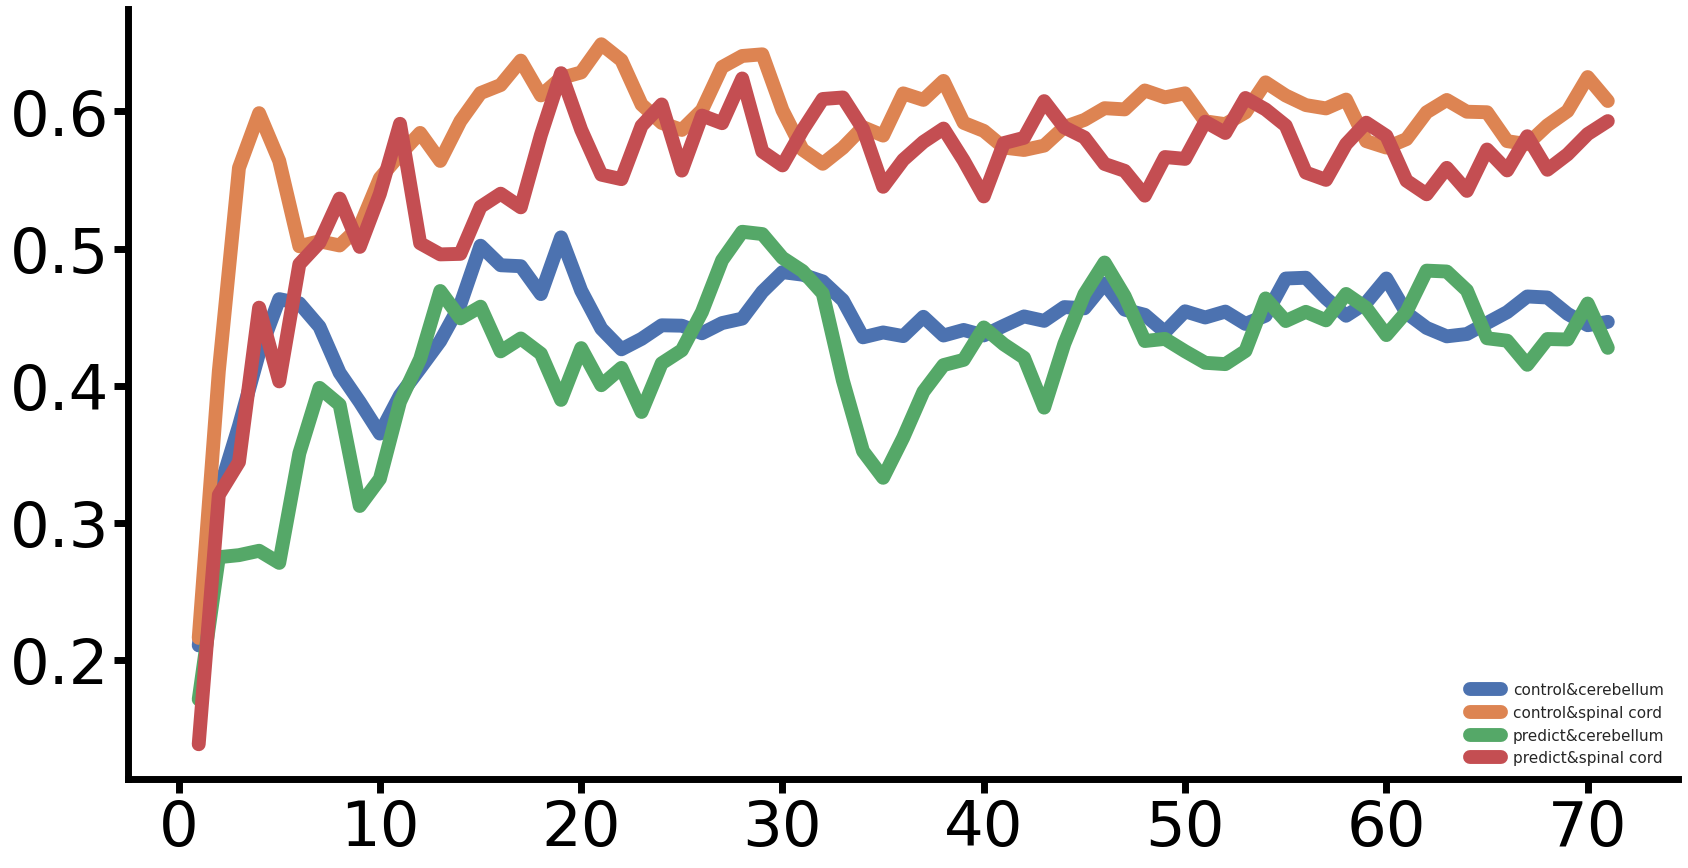

In [9]:
result = {'control&cerebellum': [], 'control&spinal cord': [], 'predict&cerebellum': [], 'predict&spinal cord': []}
for num in range(1, len(target_hic)):
    result['control&cerebellum'].append(
        cal_pearson(target_hic, _schic_range, cerebellum_interactions, _bulk_range, num))
    result['control&spinal cord'].append(
        cal_pearson(target_hic, _schic_range, spinal_cord_interactions, _bulk_range, num))
    result['predict&cerebellum'].append(
        cal_pearson(pred_hic, _schic_range, cerebellum_interactions, _bulk_range, num))
    result['predict&spinal cord'].append(
        cal_pearson(pred_hic, _schic_range, spinal_cord_interactions, _bulk_range, num))
    
set_plt(figsize=(20, 10))
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots()

def moving_average(interval, window_size):
    window = np.ones(int(window_size)) / float(window_size)
    return np.convolve(interval, window, 'same')

x = list(range(1, len(target_hic)))
for key in result.keys():
    plt.plot(x[:-1], moving_average(result[key], 3)[:-1], label=key, linewidth=figure_size['small'])

set_Border(plt.gca())
plt.tick_params(colors='black', bottom=True, left=True, labelsize=figure_size['ultra'])
plt.grid(False)

plt.legend(
    facecolor='white', loc='lower right'
).get_frame().set_linewidth(0.0)
# plt.xlabel("Pearson", fontsize=figure_size['ultra'])
# plt.ylabel("Cell Nums", fontsize=figure_size['ultra'])
plt.savefig('/lmh_data/work/SEE/analyse/figure_file/SLC1A2(single vs bulk).pdf', format='pdf', bbox_inches='tight')
plt.show()

In [10]:
def _draw(mat, title=None, ignore_diag=False):
    set_plt(figsize=(10, 10))
    sns.set_theme(style="whitegrid")

    fig, ax = plt.subplots()
    
    if ignore_diag:
        mat = mat.copy()
        np.fill_diagonal(mat, 0)
    ax = sns.heatmap(mat, cmap='Reds_r', square=True)

    set_Border(plt.gca())
    plt.grid(False)
    
    ax.set_xticks([])
    ax.set_yticks([])

    if title:
        plt.savefig(
            '/lmh_data/work/SEE/analyse/figure_file/{}.pdf'.format(title), format='pdf', bbox_inches='tight')
    plt.show()

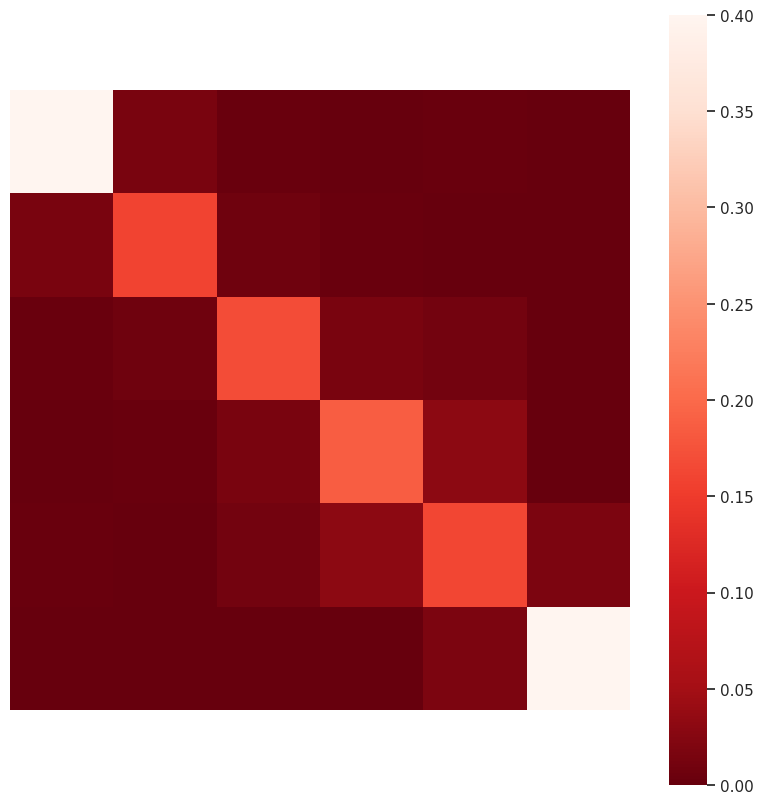

In [11]:
_mat = _reshape(array2mat(np.array(target_hic).mean(axis=0)), _bulk_shape, _bulk_range)
_mat[_mat>0.4] = 0.4
_draw(_mat, 'target hic(SLC1A2)')

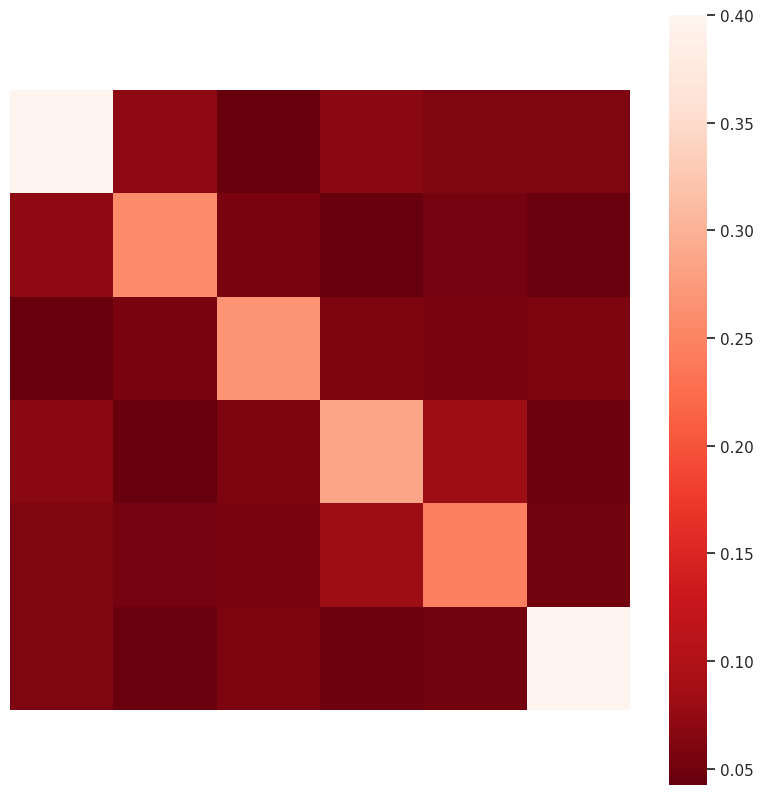

In [12]:
_mat = _reshape(array2mat(np.array(pred_hic).mean(axis=0)), _bulk_shape, _bulk_range)
_mat[_mat>0.4] = 0.4
_draw(_mat, 'predict hic(SLC1A2)')

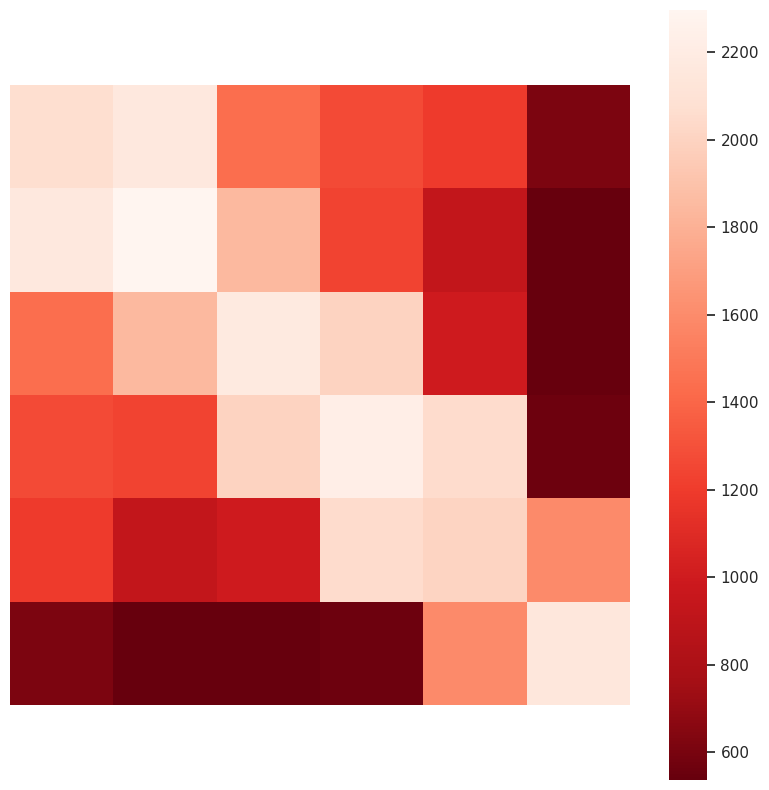

In [13]:
_draw(cerebellum_interactions, 'cerebellum hic(SLC1A2)')

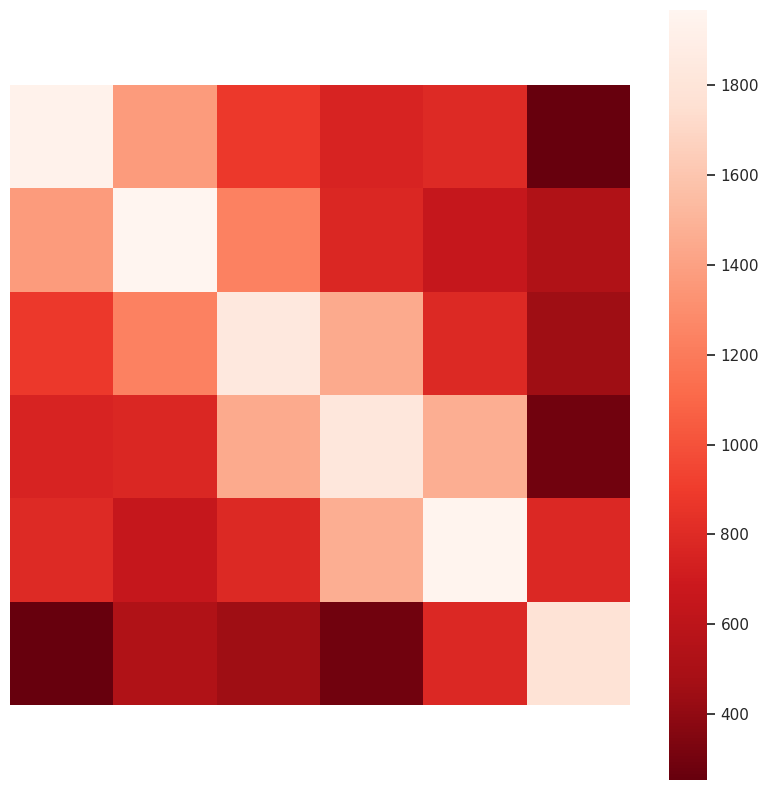

In [14]:
_draw(spinal_cord_interactions, 'spinal cord hic(SLC1A2)')